In [111]:
# First import all packages required
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import os
from openpyxl import load_workbook

import cobra
from cobra.flux_analysis.variability import flux_variability_analysis
from cobra.sampling import sample

import equilibrator_api
from equilibrator_api import ComponentContribution, Reaction, Q_, R, default_T
from equilibrator_api.model import Bounds

from equilibrator_pathway import ThermodynamicModel, Pathway, EnzymeCostModel, EnzymeCostFunction


import seaborn as sns
from matplotlib.patches import Rectangle

import math

# Disable warning messages for infeasible simulations
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir('...')

In [76]:
# Builds a COBRA model from a formatted spreadsheet.
# Also builds a dictionary of metabolites present in the model, as this will be useful later

def build_model_from_excel(path, modelname):
    
    reactions_df = pd.read_excel(path, sheet_name = 'Reactions')
    metabolites_df = pd.read_excel(path, sheet_name = 'Metabolites')

    metabolites = []
    bounds = []
    met_dict = {}
    thermo = {}

    model = cobra.Model(modelname)

    for i,row in metabolites_df.iterrows():

        metabolite = cobra.Metabolite(row['METID'])
        metabolite.id = row['METID']
        metabolite.compartment = row['COMPARTMENT']
        metabolite.name = row['NAME']
        metabolite.formula = row['FORMULA']
        metabolite.charge = row['CHARGE']

        metabolites.append(metabolite)
        met_dict[row['METID']] = row['METID_KEGG']

    model.add_metabolites(metabolites)

    for i,row in reactions_df.iterrows():

        reaction = cobra.Reaction(row['RXNID'])
        model.add_reactions([reaction])

        model.reactions.get_by_id(reaction.id).name = row['RXNID']
        model.reactions.get_by_id(reaction.id).subsystem = row['SUBSYSTEM']
        model.reactions.get_by_id(reaction.id).compartment = row['COMPARTMENT']
        model.reactions.get_by_id(reaction.id).reaction = row['EQUATION']
        
        bounds.append((row['LB'], row['UB']))
    
    for i in range(0,len(model.reactions)):
        model.reactions[i].bounds = bounds[i]
        
    cobra.io.write_sbml_model(model, modelname+'.xml')
        
    return model, met_dict

In [84]:
# Adds an assimilation module to a given COBRA model object from a formatted spreadsheet
# Also updates the metabolite dictionary with metabolites required for the assimilation module

def add_modules(model, path, module, met_dict):
    
    reactions_df = pd.read_excel(path, sheet_name = 'Reactions')
    metabolites_df = pd.read_excel(path, sheet_name = 'Metabolites')
    
    augmented_model = model.copy()

    metabolites = []
    bounds = []
    thermo = {}
    n_rxns = len(model.reactions)

    for i,row in metabolites_df.iterrows():

        metabolite = cobra.Metabolite(row['METID'])
        metabolite.id =row['METID']
        metabolite.compartment = row['COMPARTMENT']
        metabolite.name = row['NAME']
        metabolite.formula = row['FORMULA']
        metabolite.charge = row['CHARGE']

        metabolites.append(metabolite)

        met_dict[row['METID']] = row['METID_KEGG']

    augmented_model.add_metabolites(metabolites)

    for i,row in reactions_df.iterrows():
        
        if row['SUBSYSTEM'] == module:

            reaction = cobra.Reaction(row['RXNID'])
            augmented_model.add_reactions([reaction])

            augmented_model.reactions.get_by_id(reaction.id).name = row['NAME']
            augmented_model.reactions.get_by_id(reaction.id).subsystem = row['SUBSYSTEM']
            augmented_model.reactions.get_by_id(reaction.id).compartment = row['COMPARTMENT']
            augmented_model.reactions.get_by_id(reaction.id).reaction = row['EQUATION']

            bounds.append((row['LB'], row['UB']))
        else:
            continue
    
    for i in range(n_rxns,len(augmented_model.reactions)):
        augmented_model.reactions[i].bounds = bounds[i-n_rxns]
        
    cobra.io.write_sbml_model(augmented_model, model.id+'_'+module.lower()+'.xml')
        
    return augmented_model, met_dict

In [82]:
# Creates a production envelope using a given COBRA model

def production_envelope(model, carbon_source, flux_bounds, product_objective):
    
    temp = model.copy()
    
    for reaction in flux_bounds:
        temp.reactions.get_by_id(reaction).bounds = flux_bounds[reaction]
    
    temp.objective = 'BIOMASS'
    
    # Block non-native reactions
    
    temp.reactions.XFPK1.bounds = (0,0)
    temp.reactions.XFPK2.bounds = (0,0)
    temp.reactions.aclAB.bounds = (0,0)
    
    solution = cobra.flux_analysis.pfba(temp)
    
    gr_max = solution['BIOMASS']
    
    growth_rates = np.linspace(0, gr_max, 100)
    
    temp.objective = product_objective

    results = [[0 for x in range(5)] for y in range(100)]
    
    for i in range(0,100):

        temp.reactions.BIOMASS.bounds = (growth_rates[i], 1000)

        solution = cobra.flux_analysis.pfba(temp)
        
        if solution[product_objective] <= 0:
            continue
        else:
            #Store desired fluxes in results array
            results[i][0] = solution[product_objective] #PHB flux
            results[i][1] = solution['BIOMASS'] #Biomass production
            results[i][2] = -solution['Ex_CO2']
            results[i][3] = solution['Ex_H2']
            results[i][4] = solution['RUBISCO']
        
    df = pd.DataFrame(results) #Convert results array to dataframe
    df = df.rename(index=str, columns={0: product_objective, 1:'Biomass', 2:'CO2', 3:'H2', 4:'RUBISCO'})
    df = df.loc[(df!=0).any(axis=1)]

    return df

# Stoichiometry of CO$_2$ Reassimilation

For various carbon sources, what are the costs and benefits of CO$_2$ reassimilation?

First, the H$_2$ demand for full CO$_2$ reassimilation is estimated. Then, the thermodynamic feasibility of reassimilation is estimated.

In [85]:
# Build a model for each carbon source, then check to make sure growth is possible

path = '...\\Cupriavidus_Core_PCB_Submission.xlsx'
modules_path = '...\\Consumption_Modules_PCB_Submission.xlsx'

cnec_core, cnec_dict = build_model_from_excel(path,'cnec_core')

carbon_source = {'CO2': (1, 44, 0),
                 'Formate': (1, 46, 2), 
                 'Succinate': (4, 118, 3.5), 
                 'Acetate': (2, 60, 4), 
                 'Fructose': (6, 180, 4), 
                 'Adipate':(6, 146, 4.3), 
                 'Glycerol':(3, 92, 4.67), 
                 'EG':(2, 62, 5),
                 '14BDO':(4, 90, 5.5), 
                 'EtOH':(2, 46, 6),
                 'MeOH':(1, 32, 6)}
cnec_models = {}

for carbon in carbon_source.keys():
    
    if carbon == 'CO2':
        cnec_models[carbon] = cnec_core.copy()
        cnec_models[carbon].reactions.Ex_CO2.bounds = (1,1)
        cnec_models[carbon].reactions.Ex_H2.bounds = (0,1000)
        cnec_models[carbon].objective = 'BIOMASS'

    else:
        cnec_models[carbon], cnec_dict = add_modules(cnec_core, modules_path, carbon, cnec_dict)
        cnec_models[carbon].reactions.get_by_id('Ex_'+carbon).bounds = (0,1)
        cnec_models[carbon].objective = 'BIOMASS'
    
    try:
        solution = cobra.flux_analysis.pfba(cnec_models[carbon])
        print(solution['BIOMASS'])
    except:
        print(carbon+' is infeasible')

0.025068939583855608
0.005240266205523291
0.05752444789035352
0.030012755421054027
0.10756819054936638
0.10254358102193423
0.05890639006274813
0.03493510803682182
0.0888437618987174
0.04739066972494459
0.015720798616569803


In [86]:
production_envelopes = {}
production_envelopes_H2 = {}

for carbon in carbon_source.keys():
    
    if carbon == 'CO2':
        
        flux_bounds = {'Ex_CO2':(1,1), 'Ex_H2':(-1000,1000), 'RUBISCO':(0,1000)}
        
        production_envelopes[carbon] = production_envelope(cnec_models[carbon], carbon, flux_bounds, 'Ex_PHB')
        production_envelopes_H2[carbon] = production_envelope(cnec_models[carbon], carbon, flux_bounds, 'Ex_PHB')
        
    elif carbon_source[carbon][0] == 1:
    
        production_envelopes[carbon] = production_envelope(cnec_models[carbon], carbon, 
                                                           {'Ex_CO2':(-1000,0), 'Ex_H2':(0,0), 'RUBISCO':(0,1000)}, 
                                                           'Ex_PHB')    
        production_envelopes_H2[carbon] = production_envelope(cnec_models[carbon], carbon, 
                                                              {'Ex_CO2':(-1000,0), 'Ex_H2':(-1000,1000), 'RUBISCO':(0,1000)}, 
                                                              'Ex_PHB')
        
    else:
    
        production_envelopes[carbon] = production_envelope(cnec_models[carbon], carbon, 
                                                           {'Ex_CO2':(-1000,0), 'Ex_H2':(0,0), 'RUBISCO':(0,0)}, 
                                                           'Ex_PHB')
        
        production_envelopes_H2[carbon] = production_envelope(cnec_models[carbon], carbon, 
                                                              {'Ex_CO2':(-1000,0), 'Ex_H2':(-1000,1000), 'RUBISCO':(0,1000)}, 
                                                              'Ex_PHB')

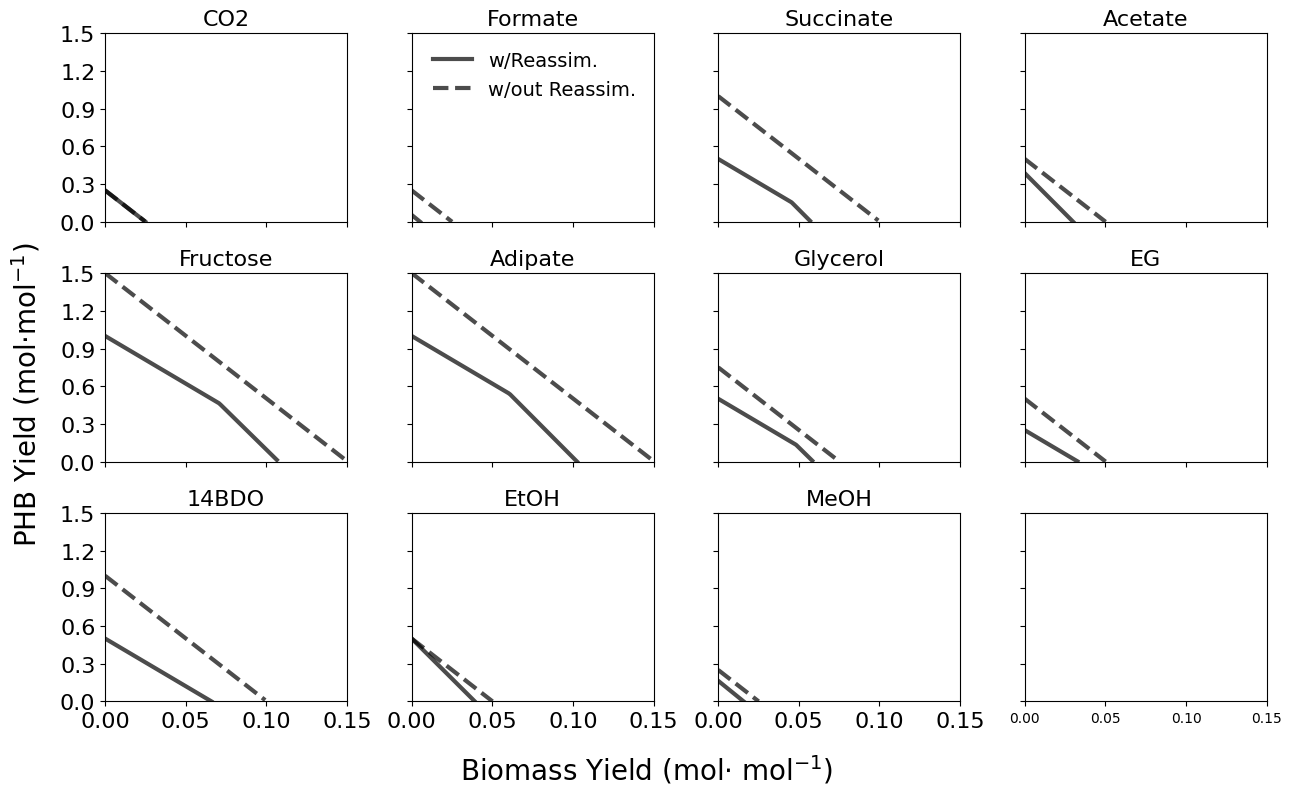

In [87]:
fig, ax = plt.subplots(3,4, figsize = (13,8), sharex = True, sharey = True)

ax = ax.flatten()
i = 0

for carbon in carbon_source.keys():
    
    ax[i].plot(production_envelopes[carbon]['Biomass'], production_envelopes[carbon]['Ex_PHB'], 
               color = 'k', linewidth = 3, alpha = 0.7, label = r'w/Reassim.')
    ax[i].plot(production_envelopes_H2[carbon]['Biomass'], production_envelopes_H2[carbon]['Ex_PHB'], 
               color = 'k', linewidth = 3, linestyle = '--', alpha = 0.7, label = r'w/out Reassim.')

    ax[i].set_title(carbon,fontsize=16)
    ax[i].tick_params(axis='both', labelsize=16)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax[i].set_xlim(0,0.15)
    ax[i].set_ylim(0,1.5)
    
    if carbon == 'Formate':
        ax[i].legend(frameon=False, loc='best', fontsize=14)
    
    i += 1

fig.supylabel(r'PHB Yield (mol$\cdot$mol$^{-1}$)', fontsize=20, x = 0.01)
fig.supxlabel(r'Biomass Yield (mol$\cdot$ mol$^{-1}$)', fontsize=20, y = 0.01)
fig.tight_layout()

#plt.savefig('production_envelopes.pdf', bbox_inches='tight')

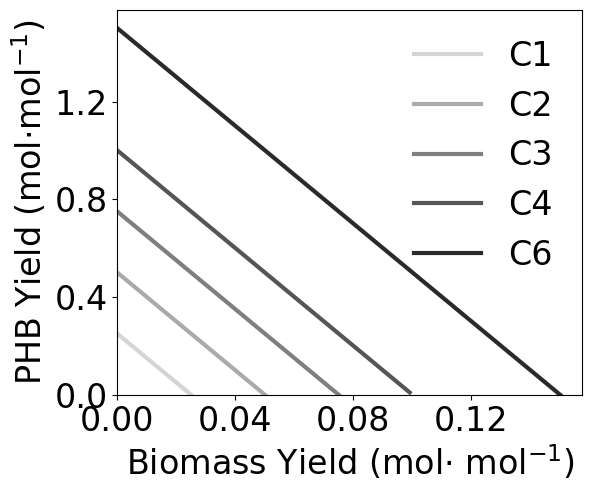

In [88]:
# Maybe delete this? It seems obvious that giving unrestricted hydrogen would drop CO2 flux to zero

shortlist = ['Formate', 'EG', 'Glycerol', '14BDO', 'Fructose']

fig, ax = plt.subplots(1,1, figsize = (6,5))

for i in range(0,len(shortlist)):  
    
    carbon = shortlist[i]
    shade = (i+1)/(len(shortlist) + 1)
    label = str(carbon_source[carbon][0])
    
    ax.plot(production_envelopes_H2[carbon]['Biomass'], production_envelopes_H2[carbon]['Ex_PHB'], 
            linewidth = 3, color = 'k', linestyle = '-', alpha = shade, label = 'C'+label)

ax.set_ylabel(r'PHB Yield (mol$\cdot$mol$^{-1}$)', fontsize=24)
ax.set_xlabel(r'Biomass Yield (mol$\cdot$ mol$^{-1}$)', fontsize=24)
ax.legend(frameon=False, loc = 'best', fontsize = 24)
ax.set_ylim(0,)
ax.set_xlim(0,)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

ax.tick_params(axis='both', labelsize=24)

#plt.savefig('stoichiometric_conversion.pdf', bbox_inches='tight')

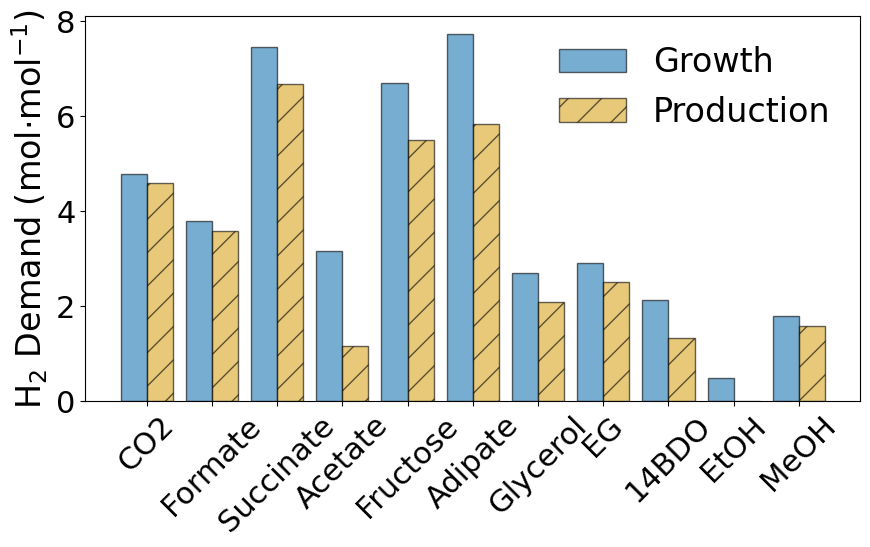

In [89]:
# Plot the hydrogen required to achieve full assimilation for growth and production extremes

x = np.arange(len(carbon_source.keys()))
growth = [production_envelopes_H2[x]['H2'][-1] for x in carbon_source.keys()]
production = [production_envelopes_H2[x]['H2'][0] for x in carbon_source.keys()]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel('H$_2$ Demand (mol$\cdot$mol$^{-1}$)', fontsize=24)
ax.legend(frameon=False, loc = 'best', fontsize = 24)
ax.tick_params(axis='both', labelsize=22)

_=ax.set_xticks(ticks = x ,labels = carbon_source.keys(), rotation =45)

#plt.savefig('H2_demand.pdf', bbox_inches = 'tight')

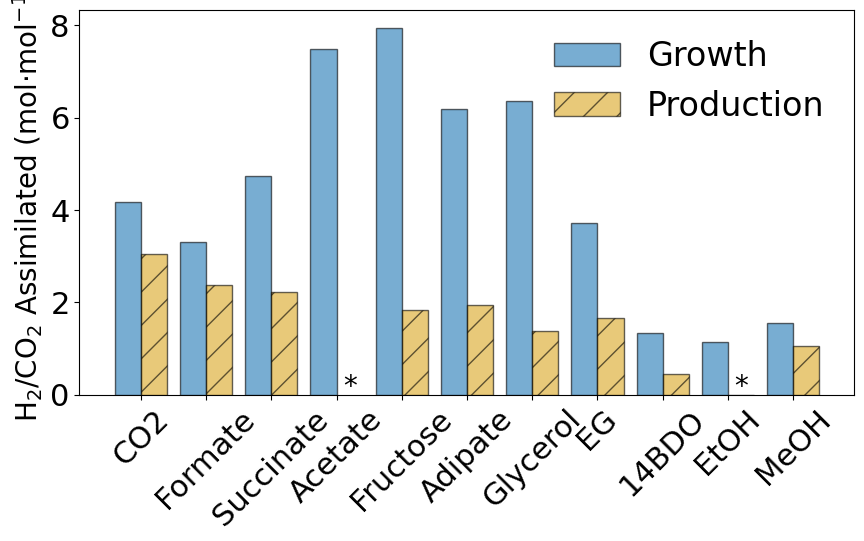

In [90]:
# Now normalize this to RUBISCO flux to account for the difference in carbon atoms in each carbon source

x = np.arange(len(carbon_source.keys()))
growth = [production_envelopes_H2[x]['H2'][-1]/production_envelopes_H2[x]['RUBISCO'][-1] for x in carbon_source.keys()]
production = [production_envelopes_H2[x]['H2'][0]/production_envelopes_H2[x]['RUBISCO'][0] for x in carbon_source.keys()]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

#ax.axhline(1, linestyle='--', linewidth = 0.75, color = 'k', alpha = 0.6)

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black", zorder=10)
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black", zorder=10)

ax.text(3.1, 0, '*', fontsize=20)
ax.text(9.1, 0, '*', fontsize=20)

ax.set_ylabel(r'H$_2$/CO$_2$ Assimilated (mol$\cdot$mol$^{-1}$)', fontsize=20)
ax.legend(frameon=False, loc = 'best', fontsize = 24)
ax.tick_params(axis='both', labelsize=22)

_=ax.set_xticks(ticks = x ,labels = carbon_source.keys(), rotation =45)

#plt.savefig('H2_per_RUBISCO.pdf', bbox_inches = 'tight')

Text(4.7, 0.93, 'MeOH')

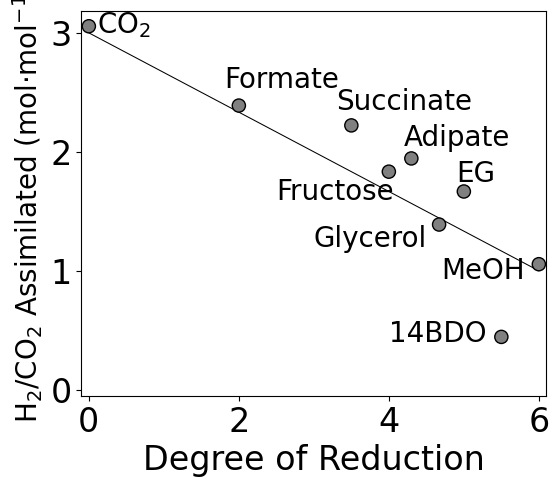

In [91]:
#production[3] = 0
production[9] = np.inf # Correct for EtOH
DOR = [carbon_source[x][2] for x in carbon_source.keys()]
demand = [(4.5-x/2)/1.5 for x in DOR]

fig, ax = plt.subplots(1,1, figsize = (6,5))

ax.scatter(DOR, production, color = 'grey', edgecolors = 'k', sizes = 90*np.ones(len(DOR)))
ax.plot(DOR, demand, linestyle = '-', linewidth = 0.75, color = 'k', zorder=0)

ax.set_xlabel(r'Degree of Reduction', fontsize=24)
ax.set_ylabel(r'H$_2$/CO$_2$ Assimilated (mol$\cdot$mol$^{-1}$)', fontsize=20)
ax.tick_params(axis='both', labelsize=24)
ax.set_ylim(-0.05,)
ax.set_xlim(-0.1,6.1)

ax.text(0.11, 3, 'CO$_2$', fontsize=20)
ax.text(1.8, 2.54, 'Formate', fontsize=20)
ax.text(3.3, 2.35, 'Succinate', fontsize=20)
#ax.text(3,0.05,'Acetate', fontsize = 12)
ax.text(2.5, 1.6, 'Fructose', fontsize=20)
ax.text(4.2, 2.05, 'Adipate', fontsize=20)
ax.text(3, 1.2, 'Glycerol', fontsize=20)
ax.text(4.9, 1.75, 'EG', fontsize=20)
#ax.text(5.3,0.05,'EtOH', fontsize = 12)
ax.text(4,0.4, '14BDO', fontsize=20)
ax.text(4.7,0.93, 'MeOH', fontsize=20)


#plt.savefig('H2_per_DOR.pdf', bbox_inches = 'tight')

In [815]:
yields = {}

for carbon in carbon_source:
    if carbon_source[carbon][0] == 1:
        continue
    else:
        rubisco = np.linspace(0, carbon_source[carbon][0],20)

        cnec_models[carbon].objective = 'BIOMASS'
        cnec_models[carbon].reactions.get_by_id('Ex_H2').bounds = (0,0)
        cnec_models[carbon].reactions.get_by_id('Ex_CO2').bounds = (-1000,0)
        
        temp = []

        for lb in rubisco:
            cnec_models[carb].reactions.get_by_id('RUBISCO').bounds = (lb,1000)
            solution = cobra.flux_analysis.pfba(cnec_models[carbon])
            temp.append(solution['BIOMASS'])
    
    yields[carbon] = [rubisco/carbon_source[carbon][0], temp]

In [822]:
yields_phb = {}

for carbon in carbon_source:
    if carbon_source[carbon][0] == 1:
        continue
    else:
        rubisco = np.linspace(0, carbon_source[carbon][0],20)

        cnec_models[carbon].objective = 'Ex_PHB'
        cnec_models[carbon].reactions.get_by_id('Ex_H2').bounds = (0,0)
        cnec_models[carbon].reactions.get_by_id('Ex_CO2').bounds = (-1000,0)
        
        temp = []

        for lb in rubisco:
            cnec_models[carb].reactions.get_by_id('RUBISCO').bounds = (lb,1000)
            solution = cobra.flux_analysis.pfba(cnec_models[carbon])
            temp.append(solution['Ex_PHB'])
    
    yields_phb[carbon] = [rubisco/carbon_source[carbon][0], temp]

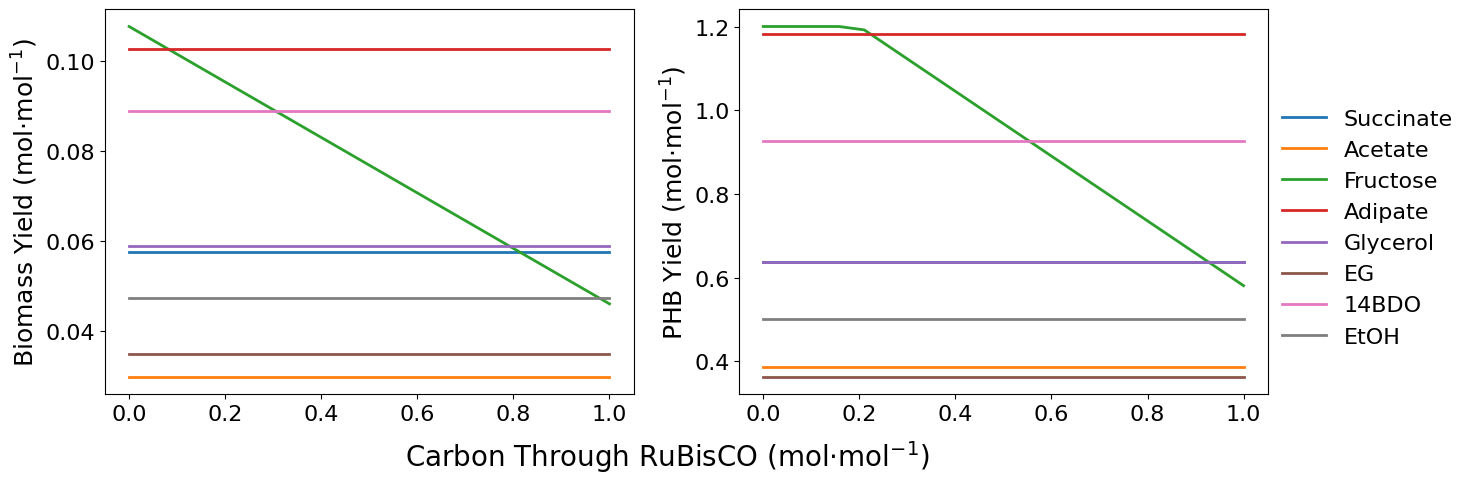

In [831]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax = ax.flatten()

for carbon in yields:
    ax[0].plot(yields[carbon][0], yields[carbon][1], linewidth = 2)
    ax[1].plot(yields_phb[carbon][0], yields_phb[carbon][1], label = carbon, linewidth = 2)

ax[0].set_ylabel(r'Biomass Yield (mol$\cdot$mol$^{-1}$)', fontsize=18)
ax[1].set_ylabel(r'PHB Yield (mol$\cdot$mol$^{-1}$)', fontsize=18)
ax[1].legend(frameon=False, loc = (1.01, 0.1), fontsize = 16)

ax[0].tick_params(axis='both', labelsize=16)
ax[1].tick_params(axis='both', labelsize=16)

fig.supxlabel(r'Carbon Through RuBisCO (mol$\cdot$mol$^{-1}$)', fontsize=20, y = -0.05)

#plt.savefig('yield_rubisco.pdf', bbox_inches = 'tight')

# Thermodynamic Analysis

In [92]:
# Establish thermodynamic conditions

C_necator_con = {
            "p_h": str(Q_("7.4")),
            "p_mg": str(Q_(3)),
            "ionic_strength": str(Q_('200 mM')),
            "temperature": str(Q_(30+273.15,"K")),
            "kcat_source": "fwd",
}

cc= ComponentContribution()

# Create a metabolite dictionary for thermodynamic model generation

compound_dict = {}

for name in cnec_dict.keys():
    try:
        compound_dict[name] = cc.get_compound(cnec_dict[name])
    except:
        continue

# Set default bounds for thermodynamic models
        
bounds = Bounds(default_lb = Q_(1e-6,'molar'),
                default_ub = Q_(1e-2,'molar'))

In [146]:
# Tranlates reactions from a COBRA model into a format that the thermodynamic package understands using a dictionary object

def translate_reactions(model, met_dict):
    
    Nr = len(model.reactions)

    translated = {}

    for i in range(0,Nr):
        reaction_id = model.reactions[i].id
        
        temp = str(model.reactions[i].reaction)
        temp = temp.split(' ')

        s = ''

        for item in temp:
            if item in met_dict:
                if type(met_dict[item]) == float:
                    s += ' '+item
                else:
                    s += ' '+met_dict[item]
            else:
                s += ' '+item

        try:
            reaction_object = cc.parse_reaction_formula(s)
            translated[reaction_id] = reaction_object
        except:
            continue
    
    return translated

In [94]:
# Gets flux distribution using pFBA for a COBRA model, given some flux bounds
# This is in preparation for building a thermodynamic model, so transport, export, and biomass fluxes 
# are excluded from the return

def get_fluxes(model, flux_bounds, objective):
    
    model.objective = objective
    
    for reaction in flux_bounds:
        model.reactions.get_by_id(reaction).bounds = flux_bounds[reaction]
 
    solution = cobra.flux_analysis.pfba(model)
    
    fluxes = [solution[x.id] for x in model.reactions if 'Ex_' not in x.id and 'Trp_' not in x.id and 'BIOMASS' not in x.id]
   
    return fluxes

In [95]:
# From a COBRA model, dictionaries for metabolites and thermodynamic compounds, and fluxes, creates a thermodynamic model

def build_thermo_model(model, cnec_dict, compound_dict, fluxes):

    translated = translate_reactions(model, cnec_dict)

    stoichiometry = cobra.util.array.create_stoichiometric_matrix(model)

    stoich = pd.DataFrame(stoichiometry,index=[x.id for x in model.metabolites], 
                          columns = [x.id for x in model.reactions])
    stoich = stoich.drop(columns=['Ex_Biomass','BIOMASS', 'Ex_PHB'])
    stoich = stoich.drop(['biomass[c]','PHB[c]'])
    stoich = stoich.drop(columns=[x for x in stoich.columns if 'Ex_' in x or 'Trp_' in x])
    
    fluxes = Q_(fluxes)

    thermo_model = ThermodynamicModel(S = stoich,
                                 compound_dict = compound_dict,
                                 reaction_dict= translated,
                                 fluxes = fluxes,
                                 comp_contrib = cc,
                                 bounds=bounds)

    
    return thermo_model

In [147]:
for carbon in cnec_models.keys():
    cnec_models[carbon].objective = 'Ex_PHB'

In [148]:
thermo_models_no_rubisco = {}
thermo_models = {}

for carbon in carbon_source.keys():
    
    if carbon_source[carbon][0] != 1:
        
        uptake_flux = 'Ex_'+carbon
    
        flux_bounds = {'Ex_CO2': (-1000,1000), 'Ex_H2': (0, 0), 'RUBISCO': (0,0), uptake_flux: (1,1)}
        fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'Ex_PHB')
        thermo_models_no_rubisco[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)

        flux_bounds = {'Ex_CO2': (-1000,1000), 'Ex_H2': (0, 0), 'RUBISCO': (0,1000), uptake_flux: (1,1)}
        fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'Ex_PHB')
        thermo_models[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)
    else:
        continue

In [149]:
nonc1mdfs_no_rubisco = {}
nonc1mdfs = {}

for carbon in thermo_models_no_rubisco.keys():
    
    nonc1mdfs_no_rubisco[carbon] = thermo_models_no_rubisco[carbon].mdf_analysis().score
    nonc1mdfs[carbon] = thermo_models[carbon].mdf_analysis().score

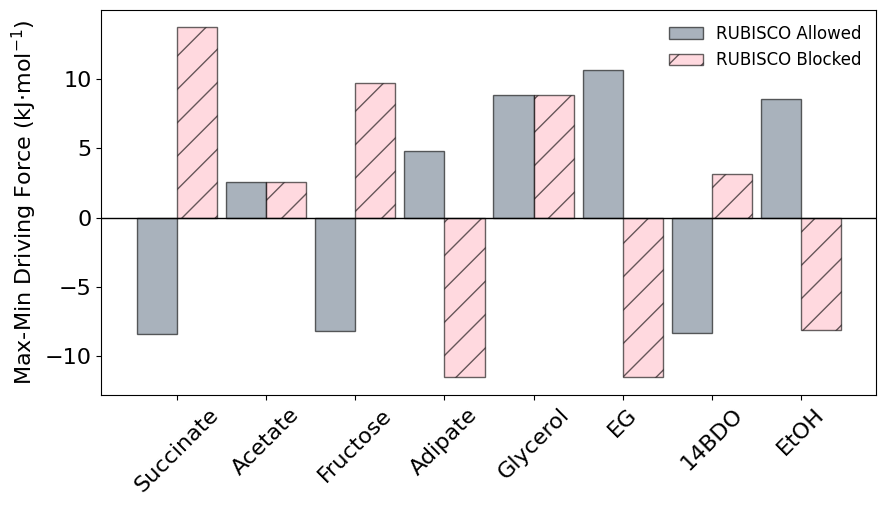

In [150]:
x = np.arange(len(nonc1mdfs.keys())) 
rubisco = [nonc1mdfs[x] for x in nonc1mdfs.keys()]
no_rubisco = [nonc1mdfs_no_rubisco[x] for x in nonc1mdfs_no_rubisco.keys()]
width = 0.45

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, rubisco, width, label = 'RUBISCO Allowed', alpha = 0.6, color = 'slategrey', edgecolor = "black")
ax.bar(x+width/2, no_rubisco, width, label = 'RUBISCO Blocked', color = 'pink',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 12)
ax.tick_params(axis='both', labelsize=16)

ax.axhline(0,linewidth = 1, color = 'k')

_=ax.set_xticks(ticks = x, labels = nonc1mdfs.keys(), rotation =45)

#plt.savefig('rubisco_requirement.pdf', bbox_inches = 'tight')

In [151]:
# Set appropriate RUBISCO bounds based on above 

cnec_models['CO2'].reactions.get_by_id('RUBISCO').bounds = (0,1000)
cnec_models['Formate'].reactions.get_by_id('RUBISCO').bounds = (0,1000)
cnec_models['Succinate'].reactions.get_by_id('RUBISCO').bounds = (0,0)
cnec_models['Acetate'].reactions.get_by_id('RUBISCO').bounds = (0,1000)
cnec_models['Fructose'].reactions.get_by_id('RUBISCO').bounds = (0,0)
cnec_models['Adipate'].reactions.get_by_id('RUBISCO').bounds = (0,1000)
cnec_models['Glycerol'].reactions.get_by_id('RUBISCO').bounds = (0,1000)
cnec_models['EG'].reactions.get_by_id('RUBISCO').bounds = (0,1000)
cnec_models['14BDO'].reactions.get_by_id('RUBISCO').bounds = (0,0)
cnec_models['EtOH'].reactions.get_by_id('RUBISCO').bounds = (0,1000)
cnec_models['MeOH'].reactions.get_by_id('RUBISCO').bounds = (0,1000)
cnec_models['MeOH'].reactions.get_by_id('CITS').bounds = (0,1000)

In [152]:
for carbon in carbon_source:
    cnec_models[carbon].objective = 'BIOMASS'

In [153]:
thermo_models_growth = {}
thermo_models_prod = {}

for carbon in cnec_models.keys():
    
    uptake_flux = 'Ex_'+carbon
    
    if carbon == 'CO2':
        flux_bounds = {'Ex_CO2': (1,1), 'Ex_H2': (-1000, 1000), 'RUBISCO':(0,1000)}
    
    else:
        flux_bounds = {'Ex_CO2': (-1000,1000), 'Ex_H2': (0, 0), uptake_flux:(1,1)}
    
    fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'Ex_PHB')
    thermo_models_prod[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)
    
    if carbon == 'EG':
        flux_bounds = {'Ex_CO2': (-1000,1000), 'Ex_H2': (0, 0), 'RUBISCO':(0,0), uptake_flux:(1,1)}
        
    if carbon == 'MeOH':
        flux_bounds = {'Ex_CO2': (-1000,1000), 'Ex_H2': (0, 0), 'RUBISCO':(0,1000), uptake_flux:(1,1), 'CITS':(0,0)}
    
    fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'BIOMASS')
    thermo_models_growth[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)

In [154]:
mdfs_growth = {}
mdfs_prod = {}

for carbon in thermo_models_growth.keys():

    try:
        mdfs_growth[carbon] = thermo_models_growth[carbon].mdf_analysis().score
        mdfs_prod[carbon] = thermo_models_prod[carbon].mdf_analysis().score
    except:
        print('no mdf for '+carbon)

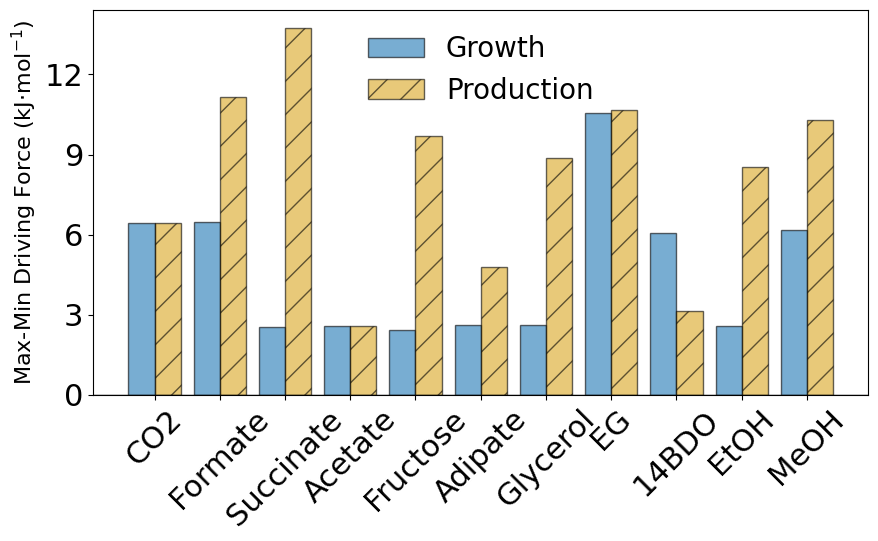

In [155]:
x = np.arange(len(mdfs_prod))
growth = [mdfs_growth[x] for x in mdfs_prod.keys()]
production = [mdfs_prod[x] for x in mdfs_prod.keys()]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 20)
ax.tick_params(axis='both', labelsize=22)
ax.axhline(0,linewidth = 1, color = 'k')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

_=ax.set_xticks(ticks = x,labels = mdfs_prod.keys(), rotation =45)

#plt.savefig('baseline mdfs.pdf', bbox_inches = 'tight')

In [162]:
for carbon in carbon_source:
    cnec_models[carbon].objective = 'Ex_PHB'

In [163]:
thermo_models_reassim_growth = {}
thermo_models_reassim_prod = {}

for carbon in cnec_models.keys():
    
    uptake_flux = 'Ex_'+carbon
    
    if carbon == 'EtOH': # Ethanol requires CO2 uptake without hydrogen
        flux_bounds = {'Ex_CO2': (-1000,1000), 'Ex_H2': (0, 0), 'RUBISCO': (0,1000)}
        flux_bounds[uptake_flux] = (1,1)
    elif carbon == 'CO2':
        flux_bounds = {'Ex_CO2': (1,1), 'Ex_H2': (-1000, 1000), 'RUBISCO': (0,1000)}
    else:
        flux_bounds = {'Ex_CO2': (0,0), 'Ex_H2': (-1000, 1000), 'RUBISCO': (0,1000)}
        flux_bounds[uptake_flux] = (1,1)
    
    cnec_models[carbon].objective = 'Ex_PHB'
    
    fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'Ex_PHB')
    thermo_models_reassim_prod[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)
    
    cnec_models[carbon].objective = 'BIOMASS'

    fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'BIOMASS')
    thermo_models_reassim_growth[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)

In [164]:
mdfs_reassim_growth = {}
mdfs_reassim_prod = {}

for carbon in thermo_models_reassim_growth.keys():

    try:
        mdfs_reassim_growth[carbon] = thermo_models_reassim_growth[carbon].mdf_analysis().score
        mdfs_reassim_prod[carbon] = thermo_models_reassim_prod[carbon].mdf_analysis().score
    except:
        print('no mdf for '+carbon)

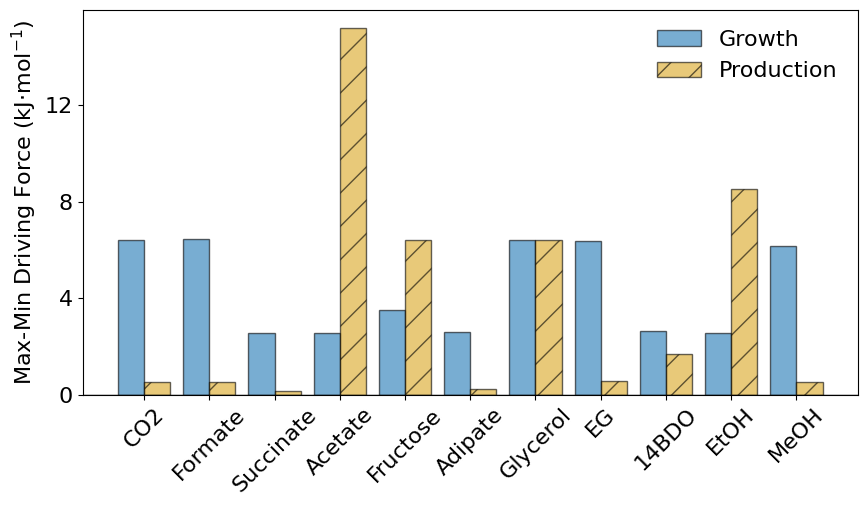

In [165]:
x = np.arange(len(mdfs_reassim_prod))
growth = [mdfs_reassim_growth[x] for x in mdfs_reassim_prod.keys()]
production = [mdfs_reassim_prod[x] for x in mdfs_reassim_prod.keys()]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 16)
ax.tick_params(axis='both', labelsize=16)
ax.axhline(0,linewidth = 1, color = 'k')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

_=ax.set_xticks(ticks = x,labels = mdfs_reassim_prod.keys(), rotation =45)

#plt.savefig('reassimilation mdfs.pdf', bbox_inches = 'tight')

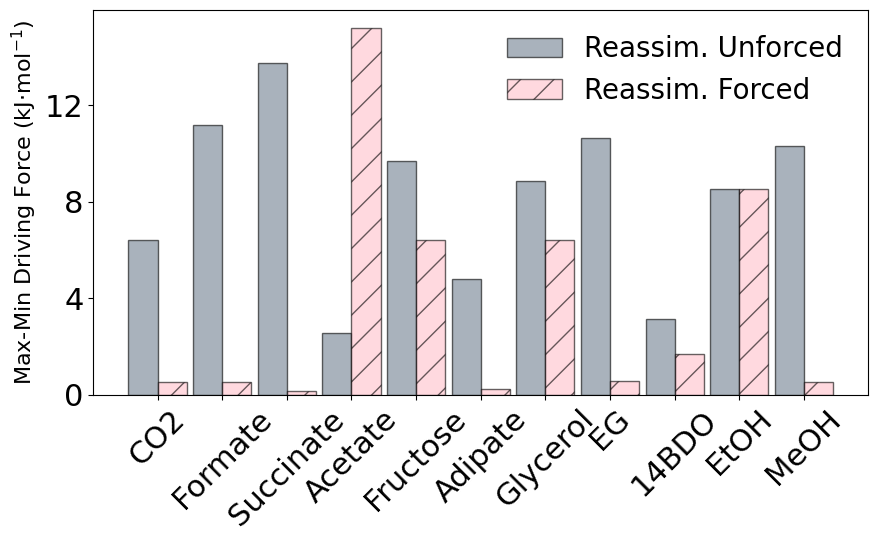

In [166]:
x = np.arange(len(mdfs_reassim_prod.keys())) 
no_reassim = [mdfs_prod[x] for x in mdfs_prod.keys()]
reassim = [mdfs_reassim_prod[x] for x in mdfs_reassim_prod.keys()]
width = 0.45

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, no_reassim, width, label = 'Reassim. Unforced', alpha = 0.6, color = 'slategrey', edgecolor = "black")
ax.bar(x+width/2, reassim, width, label = 'Reassim. Forced', color = 'pink',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 20)
ax.tick_params(axis='both', labelsize=22)

ax.yaxis.set_major_locator(plt.MaxNLocator(5))

_=ax.set_xticks(ticks = x, labels = mdfs_reassim_prod.keys(), rotation =45)

#plt.savefig('reassim_no_reassim_comparison.pdf', bbox_inches = 'tight')

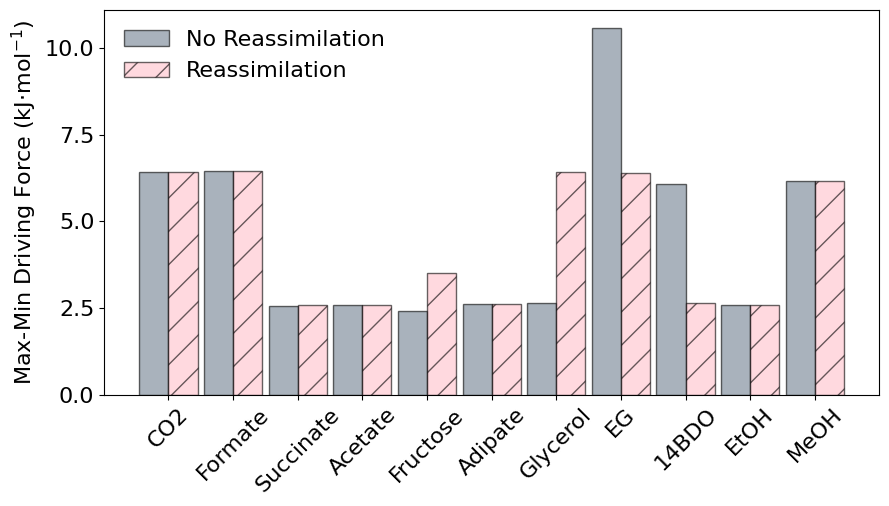

In [167]:
x = np.arange(len(mdfs_reassim_growth.keys())) 
no_reassim = [mdfs_growth[x] for x in mdfs_growth.keys()]
reassim = [mdfs_reassim_growth[x] for x in mdfs_reassim_growth.keys()]
width = 0.45

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, no_reassim, width, label = 'No Reassimilation', alpha = 0.6, color = 'slategrey', edgecolor = "black")
ax.bar(x+width/2, reassim, width, label = 'Reassimilation', color = 'pink',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 16)
ax.tick_params(axis='both', labelsize=16)

ax.yaxis.set_major_locator(plt.MaxNLocator(5))

_=ax.set_xticks(ticks = x, labels = mdfs_reassim_prod.keys(), rotation =45)

#plt.savefig('reassim_no_reassim_comparison_growth.pdf', bbox_inches = 'tight')

In [544]:
mixed_models = {}
pairs = []

for carbon1 in carbon_source:
    temp = {}
    if carbon1 == 'CO2':
        continue
    else:
        for carbon2 in carbon_source:
            if carbon2 == 'CO2':
                continue
            elif carbon1 == carbon2:
                temp[carbon2] = cnec_models[carbon1].copy()
                temp[carbon2].reactions.get_by_id('Ex_H2').bounds = (0,0)
                temp[carbon2].reactions.get_by_id('Ex_CO2').bounds = (-1000,1000)
            else:
                temp[carbon2], cnec_dict = add_modules(cnec_models[carbon1], 'Consumption modules.xlsx', carbon2, cnec_dict)
                temp[carbon2].reactions.get_by_id('Ex_'+carbon1).bounds = (1,1) #Force utilization of carbon1
                temp[carbon2].reactions.get_by_id('Ex_'+carbon2).bounds = (0,1) #Allow utilization of carbon2

                temp[carbon2].reactions.get_by_id('Ex_H2').bounds = (0,0)
                temp[carbon2].reactions.get_by_id('Ex_CO2').bounds = (-1000,1000)
    
    mixed_models[carbon1] = temp

In [545]:
c_efficiency = {}

for carbon1 in carbon_source:
    temp = {}
    if carbon1 == 'CO2':
        continue
    else:
        for carbon2 in carbon_source:
            if carbon2 == 'CO2':
                continue
            elif carbon1 == carbon2:
                try:
                    mixed_models[carbon1][carbon2].objective = 'Ex_PHB'
                    solution = cobra.flux_analysis.pfba(mixed_models[carbon1][carbon2])

                    PHB = solution['Ex_PHB']
                    C_flux = solution['Ex_'+carbon1]

                    efficiency = 4*solution['Ex_PHB']/(C_flux*carbon_source[carbon1][0])

                    temp[carbon2] = efficiency
                except:
                    print(carbon1+' infeasible')
                    temp[carbon2] = 0
            else:
                try:
                    mixed_models[carbon1][carbon2].objective = 'Ex_PHB'
                    solution = cobra.flux_analysis.pfba(mixed_models[carbon1][carbon2])

                    PHB = solution['Ex_PHB']
                    C1_flux = solution['Ex_'+carbon1]
                    C2_flux = solution['Ex_'+carbon2]

                    efficiency = 4*solution['Ex_PHB']/(C1_flux*carbon_source[carbon1][0]+C2_flux*carbon_source[carbon2][0])

                    temp[carbon2] = efficiency
                except:
                    print(carbon1+' and '+carbon2+' infeasible')
                    temp[carbon2] = 0
    c_efficiency[carbon1] = temp

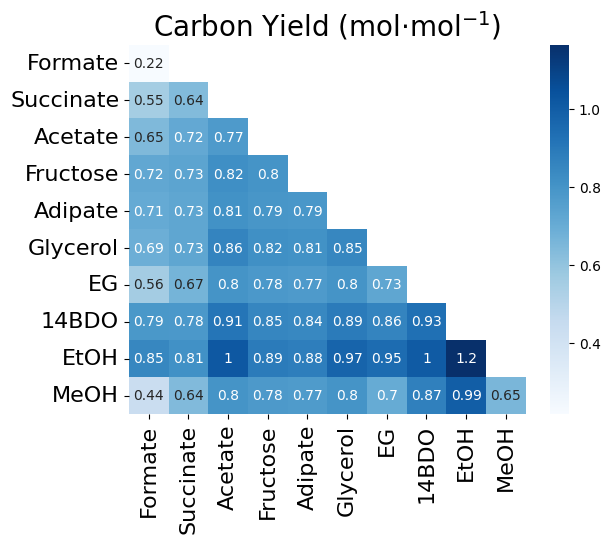

In [1036]:
efficiency_df = pd.DataFrame(c_efficiency)
mask = np.triu(np.ones_like(efficiency_df))
mask[np.diag_indices_from(mask)] = False
g = sns.heatmap(efficiency_df, cmap = 'Blues', annot=True, mask=mask)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 16)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 16)

plt.title('Carbon Yield (mol$\cdot$mol$^{-1}$)', fontsize=20)
plt.show()

figure = g.get_figure()

#figure.savefig('carbon efficiency mixotrophy.pdf',bbox_inches = 'tight')

In [969]:
c_efficiency_eco2r = {}

for carbon1 in carbon_source:
    temp = {}
    if carbon1 == 'CO2':
        continue
    else:
        for carbon2 in carbon_source:
            if carbon2 == 'CO2':
                continue
            elif carbon1 == carbon2:
                try:
                    mixed_models[carbon1][carbon2].objective = 'Ex_PHB'
                    solution = cobra.flux_analysis.pfba(mixed_models[carbon1][carbon2])

                    PHB = solution['Ex_PHB']
                    C_flux = solution['Ex_'+carbon1]

                    efficiency = 4*solution['Ex_PHB']/(C_flux*carbon_source[carbon1][0])

                    temp[carbon2] = efficiency
                except:
                    print(carbon1+' infeasible')
                    temp[carbon2] = 0
            else:
                try:
                    mixed_models[carbon1][carbon2].objective = 'Ex_PHB'
                    solution = cobra.flux_analysis.pfba(mixed_models[carbon1][carbon2])

                    PHB = solution['Ex_PHB']
                    C1_flux = solution['Ex_'+carbon1]
                    C2_flux = solution['Ex_'+carbon2]
                    
                    if carbon2 in ['Formate', 'EG', 'EtOH', 'MeOH']:
                        efficiency = 4*solution['Ex_PHB']/(C1_flux*carbon_source[carbon1][0])
                    else:
                        continue
                        #efficiency = 4*solution['Ex_PHB']/(C1_flux*carbon_source[carbon1][0]+C2_flux*carbon_source[carbon2][0])

                    temp[carbon2] = efficiency
                except:
                    print(carbon1+' and '+carbon2+' infeasible')
                    temp[carbon2] = 0
    c_efficiency_eco2r[carbon1] = temp

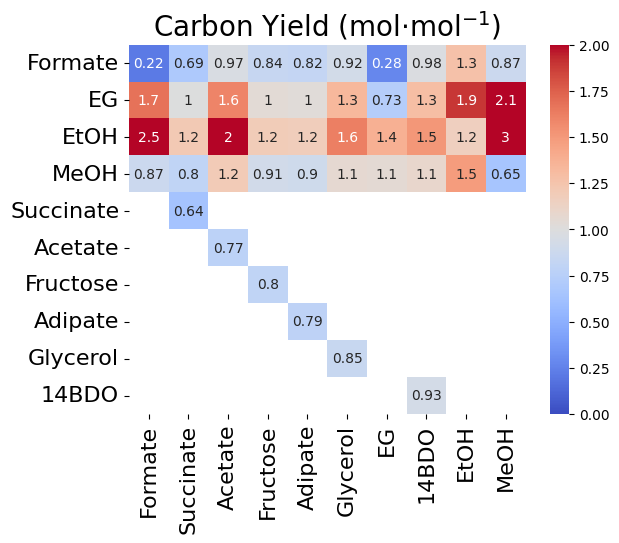

In [1038]:
efficiency_df = pd.DataFrame(c_efficiency_eco2r)

g = sns.heatmap(efficiency_df, cmap = 'coolwarm', vmin = 0, vmax = 2, annot=True)#, mask=mask)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 16)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 16)
plt.title('Carbon Yield (mol$\cdot$mol$^{-1}$)', fontsize=20)
plt.show()


figure = g.get_figure()

#figure.savefig('carbon efficiency mixotrophy eCO2R.pdf',bbox_inches = 'tight')

In [73]:
for carbon in cnec_models.keys():
    cnec_models[carbon].objective = 'Ex_PHB'

In [80]:
mixed_mdfs = {}

for carbon1 in carbon_source:
    temp = {}
    if carbon1 == 'CO2':
        continue
    else:
        for carbon2 in carbon_source:
            if carbon2 == 'CO2':
                continue
            elif carbon1 == carbon2:

                uptake_flux = 'Ex_'+carbon1
                
                # Justified by analysis above, which shows that these substrates are only feasible when RUBISCO is blocked
                if carbon1 == 'Fructose' or carbon1 == 'Succinate' or carbon1 == '14BDO':
                    flux_bounds = {'Ex_CO2':(-1000,1000), 'Ex_H2':(0,0), 'RUBISCO':(0,0), uptake_flux:(1,1)}
                else:
                    flux_bounds = {'Ex_CO2':(-1000,1000), 'Ex_H2':(0,0), 'RUBISCO':(0,1000), uptake_flux:(1,1)}

                fluxes = get_fluxes(mixed_models[carbon1][carbon2], flux_bounds, 'Ex_PHB')
                model = build_thermo_model(mixed_models[carbon1][carbon2], cnec_dict, compound_dict, fluxes)
                temp[carbon2] = model.mdf_analysis().score 

            else:
                uptake_flux1 = 'Ex_'+carbon1
                uptake_flux2 = 'Ex_'+carbon2
                    
                flux_bounds = {'Ex_CO2':(-1000,1000), 'Ex_H2':(0,0), 'RUBISCO':(0,1000), uptake_flux1:(0,1), uptake_flux2:(0,1)}

                fluxes = get_fluxes(mixed_models[carbon1][carbon2], flux_bounds, 'Ex_PHB')
                model = build_thermo_model(mixed_models[carbon1][carbon2], cnec_dict, compound_dict, fluxes)
                temp[carbon2] = model.mdf_analysis().score 
                
    mixed_mdfs[carbon1] = temp

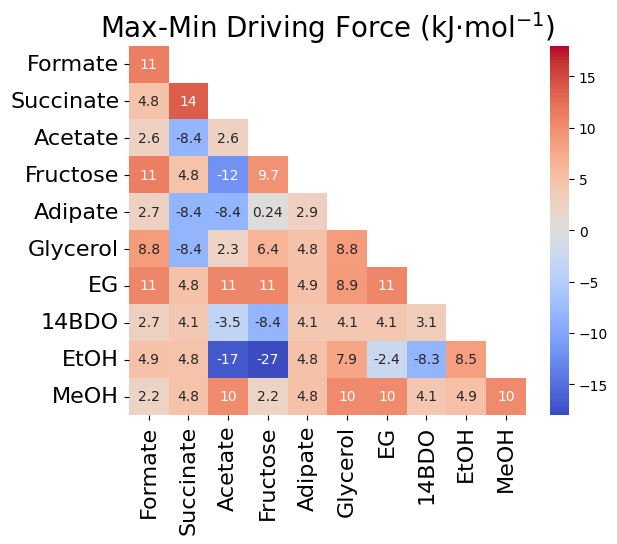

In [1037]:
mdfs_df = pd.DataFrame(mixed_mdfs)
mask = np.triu(np.ones_like(mdfs_df))
mask[np.diag_indices_from(mask)] = False

fig, ax = plt.subplots(1,1)
g = sns.heatmap(mdfs_df, cmap = 'coolwarm', vmin = -18, vmax = 18, annot=True, mask=mask, ax=ax)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 16)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 16)
plt.title('Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=20)

figure = g.get_figure()

plt.show()
#figure.savefig('mixed_mdfs.pdf',bbox_inches='tight')

# CO$_2$-Free Mixotrophy

Of these scenarios, only ethanol alone is CO$_2$-free, even though C-C mixotrophy increases carbon efficiency. In order to yield CO$_2$-free mixotrophy, the paired carbon source must at least be able to drive assimilation of all of the CO$_2$ its oxidation produces. We know from the DOR analysis before that this is only possible if the carbon source does not have to fix any CO$_2$ at all! 

Acetate and ethanol are two such cases, though acetate does not generate its own energy and therefore must be paired with a CO$_2$-free energy source. Ethanol seems to produce sufficient energy to drive its own polymerization.

This line of thinking raises another possibility: partial oxidation + export of a valuable product. This is possible for glycerol (marginally) and EG (definitely), which can be partially oxidized to valuable acids, generated two reducing equivalents along the way.

In [1051]:
cnec_models['EG_GA'] = cnec_models['EG'].copy()
cnec_models['EG_GA'].reactions.get_by_id('Trp_GA').bounds = (-1000,1000)
cnec_models['EG_GA'].reactions.get_by_id('Ex_GA').bounds = (-1000,0)
cnec_models['EG_GA'].reactions.get_by_id('GDH').bounds = (0,0)
cnec_models['EG_GA'].objective = 'Ex_PHB'

cnec_models['Glycerol_HP'] = cnec_models['Glycerol'].copy()
cnec_models['Glycerol_HP'].reactions.get_by_id('Ex_3HP').bounds = (-1000,1000)
cnec_models['Glycerol_HP'].reactions.get_by_id('Trp_3HP').bounds = (-1000,0)
cnec_models['Glycerol_HP'].reactions.get_by_id('GLDH').bounds = (-1000,1000)
cnec_models['Glycerol_HP'].reactions.get_by_id('HPADH').bounds = (0,1000)
cnec_models['Glycerol_HP'].reactions.get_by_id('GLYK').bounds = (0,0)
cnec_models['Glycerol_HP'].objective = 'Ex_PHB'

In [1052]:
reassim_growth = {}
reassim_prod = {}

for carbon in cnec_models.keys():
    
    if carbon == 'EG_GA':
        uptake_flux = 'Ex_EG'
        flux_bounds = {'Ex_CO2': (0,1000), 'Ex_H2': (0, 0), 'RUBISCO': (0,1000), uptake_flux:(1,1)}
    elif carbon == 'Glycerol_HP':
        uptake_flux = 'Ex_Glycerol'
        flux_bounds = {'Ex_CO2': (0,1000), 'Ex_H2': (0, 0), 'RUBISCO': (0,1000), uptake_flux:(0,1)}
    else:
        uptake_flux = 'Ex_'+carbon
        flux_bounds = {'Ex_CO2': (0,1000), 'Ex_H2': (0, 0), 'RUBISCO': (0,1000), uptake_flux:(1,1)}
    
    if carbon == 'CO2':
        continue
    else:
        cnec_models[carbon].objective = 'Ex_PHB'
        
        try:
            fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'Ex_PHB')
            reassim_prod[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)
        except:
            continue
        
        cnec_models[carbon].objective = 'BIOMASS'
        
        try:
            fluxes = get_fluxes(cnec_models[carbon], flux_bounds, 'BIOMASS')
            reassim_growth[carbon] = build_thermo_model(cnec_models[carbon], cnec_dict, compound_dict, fluxes)
        except:
            continue
        

mdfs_reassim_growth = {}
mdfs_reassim_prod = {}

for carbon in reassim_growth.keys():
    try:
        mdfs_reassim_growth[carbon] = reassim_growth[carbon].mdf_analysis().score
        mdfs_reassim_prod[carbon] = reassim_prod[carbon].mdf_analysis().score
    except:
        continue

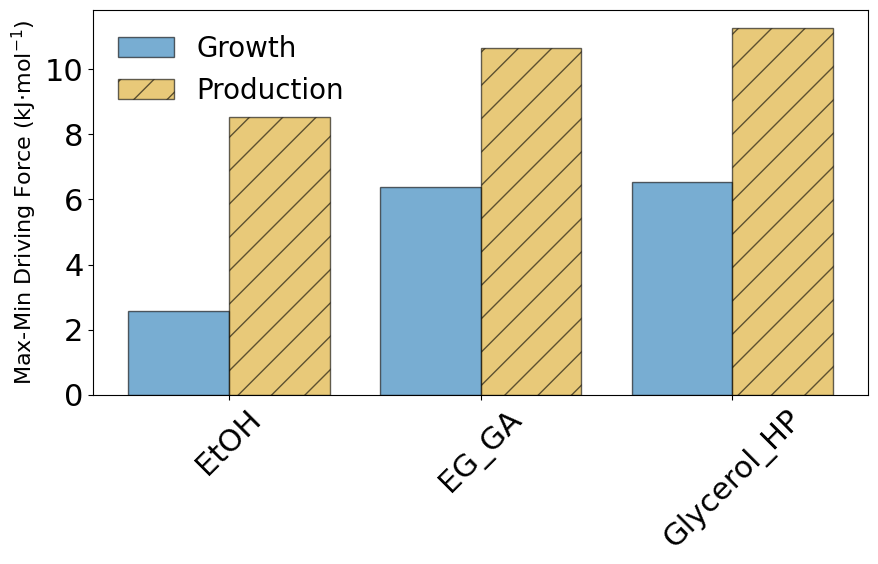

In [1054]:
x = np.arange(len(mdfs_reassim_growth.keys()))
growth = [mdfs_reassim_growth[x] for x in mdfs_reassim_growth.keys()]
production = [mdfs_reassim_prod[x] for x in mdfs_reassim_growth.keys()]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)

ax.legend(frameon=False, loc = 'best', fontsize = 20)
ax.tick_params(axis='both', labelsize=22)

_=ax.set_xticks(ticks = x,labels = mdfs_reassim_growth.keys(), rotation =45)

plt.savefig('reassimilation mdfs no H2.pdf', bbox_inches = 'tight')

Of all the single carbon sources, only ethanol, EG with GA overflow, and glycerol with 3HP overflow can support CO$_2$-free fermentation! In the latter two scenarios, valuable acids are co-products alongside the polymer.

In [1055]:
eg_pairs_production = {}

for carbon in carbon_source:
    
    if carbon == 'CO2':
        continue
    else:
        flux_bounds = {'Ex_CO2': (0,1000), 
                       'Ex_H2': (0,0), 
                       'RUBISCO': (0,1000),
                       'Ex_'+carbon:(0,1), 
                       'Ex_GA':(-1000,0), 
                       'Trp_GA':(-1000,1000), 
                       'GDH':(0,0)}
        
        flux_bounds['Ex_EG'] = (0,1)
        
        mixed_models['EG'][carbon].objective = 'Ex_PHB'
        fluxes = get_fluxes(mixed_models['EG'][carbon], flux_bounds, 'Ex_PHB')
        test_model = build_thermo_model(mixed_models['EG'][carbon], cnec_dict, compound_dict, fluxes)
        mdf_sol = test_model.mdf_analysis().score
        
        solution = cobra.flux_analysis.pfba(mixed_models['EG'][carbon])

        co2flux = solution['Ex_CO2']
        phbflux = 4*solution['Ex_PHB']/(4*solution['Ex_PHB'] - 2*solution['Ex_GA'])
        gaflux = 2*solution['Ex_GA']/(4*solution['Ex_PHB'] - 2*solution['Ex_GA'])
        
    
    eg_pairs_production[carbon] = (mdf_sol, co2flux, phbflux, gaflux)

In [1056]:
eg_pairs_growth = {}

for carbon in carbon_source:
    
    if carbon == 'CO2':
        continue
    else:
        flux_bounds = {'Ex_CO2': (0,1000), 
                       'Ex_H2': (0,0), 
                       'RUBISCO': (0,1000),
                       'Ex_'+carbon:(0,1), 
                       'Ex_GA':(-1000,0), 
                       'Trp_GA':(-1000,1000), 
                       'GDH':(0,0)}
        
        flux_bounds['Ex_EG'] = (0,1)
        
        mixed_models['EG'][carbon].objective = 'BIOMASS'
        fluxes = get_fluxes(mixed_models['EG'][carbon], flux_bounds, 'BIOMASS')
        test_model = build_thermo_model(mixed_models['EG'][carbon], cnec_dict, compound_dict, fluxes)
        mdf_sol = test_model.mdf_analysis().score
        
        solution = cobra.flux_analysis.pfba(mixed_models['EG'][carbon])

        co2flux = solution['Ex_CO2']
        phbflux = 4*solution['Ex_PHB']/(4*solution['Ex_PHB'] - 2*solution['Ex_GA'])
        gaflux = 2*solution['Ex_GA']/(4*solution['Ex_PHB'] - 2*solution['Ex_GA'])
        
    
    eg_pairs_growth[carbon] = (mdf_sol, co2flux, phbflux, gaflux)

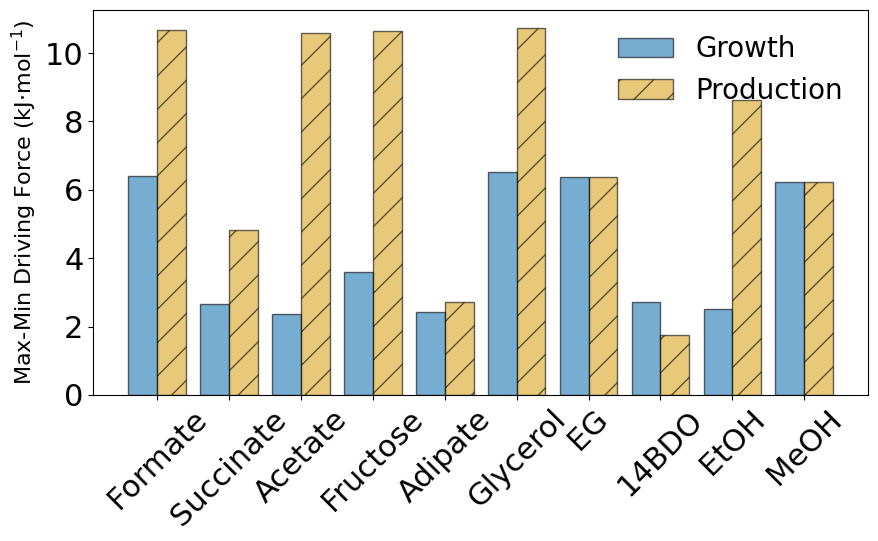

In [1057]:
x = np.arange(len(eg_pairs_growth))
growth = [eg_pairs_growth[x][0] for x in eg_pairs_growth]
production = [eg_pairs_production[x][0] for x in eg_pairs_production]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 20)
ax.tick_params(axis='both', labelsize=22)

_=ax.set_xticks(ticks = x,labels = eg_pairs_growth.keys(), rotation =45)

#plt.savefig('mixotrophic EG with GA export.pdf', bbox_inches = 'tight')

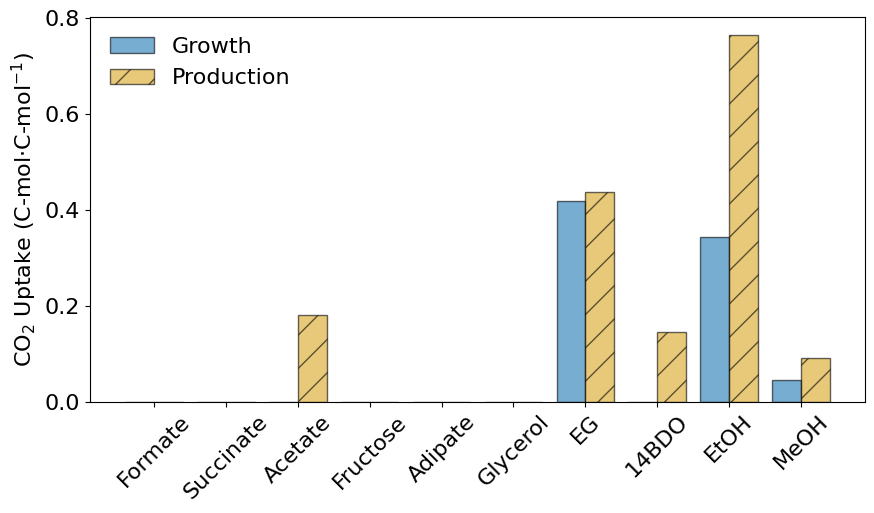

In [997]:
x = np.arange(len(eg_pairs_growth))
growth = [eg_pairs_growth[x][1] for x in eg_pairs_growth]
production = [eg_pairs_production[x][1] for x in eg_pairs_production]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'CO$_2$ Uptake (C-mol$\cdot$C-mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 16)
ax.tick_params(axis='both', labelsize=16)

_=ax.set_xticks(ticks = x,labels = eg_pairs_growth.keys(), rotation =45)

plt.savefig('mixotrophic EG CO2.pdf', bbox_inches = 'tight')

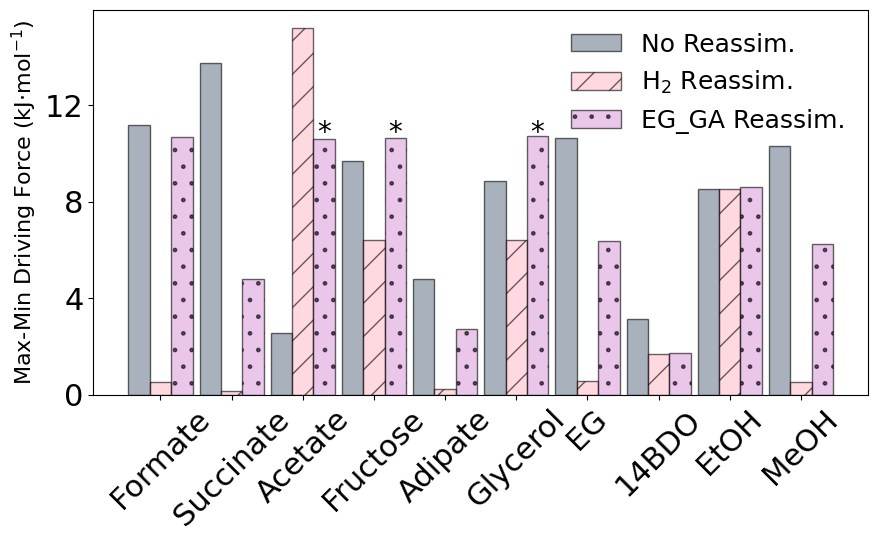

In [1064]:
x = np.arange(len(mdfs_prod.keys())-1) 
no_reassim = [mdfs_prod[x] for x in mdfs_prod.keys() if x != 'CO2']
h2_reassim = [mdfs_reassim_prod[x] for x in mdfs_reassim_prod.keys() if x != 'CO2']
eg_reassim = [eg_pairs_production[x][0] for x in eg_pairs_production]

width = 0.3

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width, no_reassim, width, label = 'No Reassim.', alpha = 0.6, color = 'slategrey', edgecolor = "black")
ax.bar(x, h2_reassim, width, label = 'H$_2$ Reassim.', color = 'pink',
       hatch = '/', alpha = 0.6, edgecolor = "black")
ax.bar(x+width, eg_reassim, width, label = 'EG_GA Reassim.', color = 'plum',
       hatch = '.', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 18)
ax.tick_params(axis='both', labelsize=22)

ax.text(2.2, 10.5, '*', fontsize=20)
ax.text(3.2, 10.5, '*', fontsize=20)
ax.text(5.2, 10.5, '*', fontsize=20)

ax.yaxis.set_major_locator(plt.MaxNLocator(5))

_=ax.set_xticks(ticks = x, labels = [x for x in mdfs_reassim_prod.keys() if x!= 'CO2'], rotation =45)

#plt.savefig('reassim_reassim_comparison_eg.pdf', bbox_inches = 'tight')

In [495]:
glyc_pairs_production = {}

for carbon in carbon_source:
    
    if carbon == 'CO2':
        continue
    else:
        flux_bounds = {'Ex_CO2': (0,1000), 
                       'Ex_H2': (0,0), 
                       'RUBISCO': (0,1000),
                       'Ex_'+carbon:(0,1), 
                       'Ex_3HP':(-1000,1000), 
                       'Trp_3HP':(-1000,0), 
                       'GLDH':(-1000,1000),
                       'HPADH':(0,1000),
                       'GLYK':(0,0)}
        
        flux_bounds['Ex_Glycerol'] = (0,1)
        
        mixed_models['Glycerol'][carbon].objective = 'Ex_PHB'
        fluxes = get_fluxes(mixed_models['Glycerol'][carbon], flux_bounds, 'Ex_PHB')
        test_model = build_thermo_model(mixed_models['Glycerol'][carbon], cnec_dict, compound_dict, fluxes)
        mdf_sol = test_model.mdf_analysis().score
        
        solution = cobra.flux_analysis.pfba(mixed_models['Glycerol'][carbon])

        co2flux = solution['Ex_CO2']
        phbflux = solution['Ex_PHB']
        hpflux = solution['Ex_3HP']
        
    
    glyc_pairs_production[carbon] = (mdf_sol, co2flux, phbflux, hpflux)

In [496]:
glyc_pairs_growth = {}

for carbon in carbon_source:
    
    if carbon == 'CO2':
        continue
    else:
        flux_bounds = {'Ex_CO2': (0,1000), 
                       'Ex_H2': (0,0), 
                       'RUBISCO': (0,1000),
                       'Ex_'+carbon:(0,1), 
                       'Ex_3HP':(-1000,1000), 
                       'Trp_3HP':(-1000,0), 
                       'GLDH':(-1000,1000),
                       'HPADH':(0,1000),
                       'GLYK':(0,0)}
        
        flux_bounds['Ex_Glycerol'] = (0,1)
        
        mixed_models['Glycerol'][carbon].objective = 'BIOMASS'
        fluxes = get_fluxes(mixed_models['Glycerol'][carbon], flux_bounds, 'BIOMASS')
        test_model = build_thermo_model(mixed_models['Glycerol'][carbon], cnec_dict, compound_dict, fluxes)
        mdf_sol = test_model.mdf_analysis().score
        
        solution = cobra.flux_analysis.pfba(mixed_models['Glycerol'][carbon])

        co2flux = solution['Ex_CO2']
        phbflux = solution['Ex_PHB']
        hpflux = solution['Ex_3HP']
        
    
    glyc_pairs_growth[carbon] = (mdf_sol, co2flux, phbflux, hpflux)

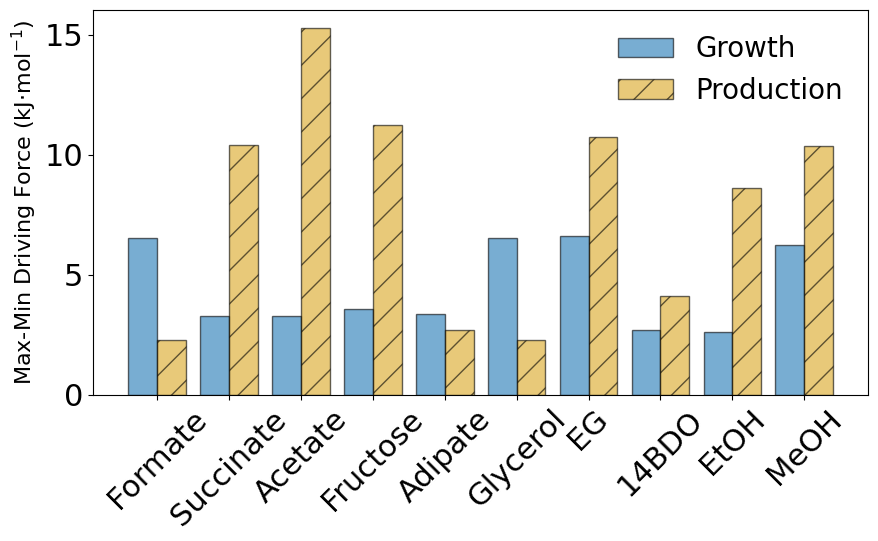

In [1049]:
x = np.arange(len(glyc_pairs_growth))
growth = [glyc_pairs_growth[x][0] for x in glyc_pairs_growth]
production = [glyc_pairs_production[x][0] for x in glyc_pairs_production]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 20)
ax.tick_params(axis='both', labelsize=22)

_=ax.set_xticks(ticks = x,labels = glyc_pairs_growth.keys(), rotation =45)

#plt.savefig('mixotrophic Glyc with HP export.pdf', bbox_inches = 'tight')

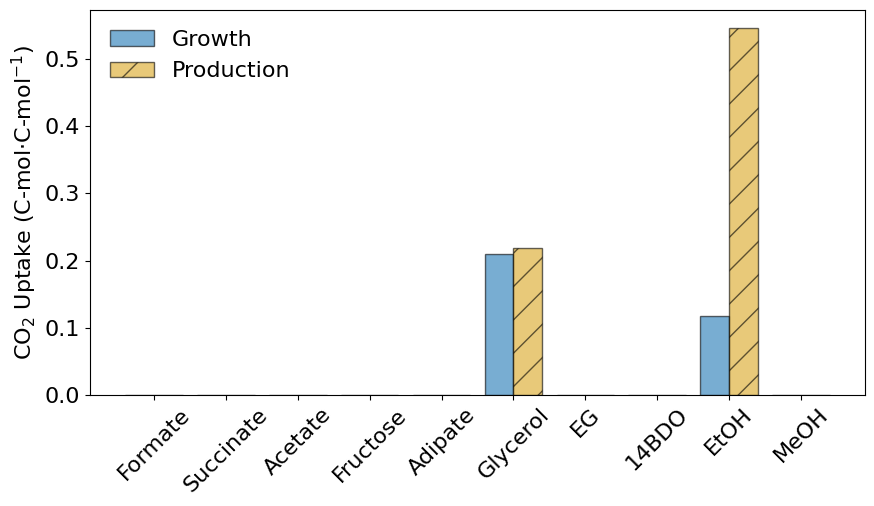

In [555]:
x = np.arange(len(eg_pairs_growth))
growth = [glyc_pairs_growth[x][1] for x in eg_pairs_growth]
production = [glyc_pairs_production[x][1] for x in eg_pairs_production]
width = 0.4

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width/2, growth, width, label = 'Growth', alpha = 0.6, edgecolor = "black")
ax.bar(x+width/2, production, width, label = 'Production', color = 'goldenrod',
       hatch = '/', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'CO$_2$ Uptake (C-mol$\cdot$C-mol$^{-1}$)', fontsize=16)
ax.legend(frameon=False, loc = 'best', fontsize = 16)
ax.tick_params(axis='both', labelsize=16)

_=ax.set_xticks(ticks = x,labels = glyc_pairs_growth.keys(), rotation =45)

#plt.savefig('mixotrophic Glyc CO2.pdf', bbox_inches = 'tight')

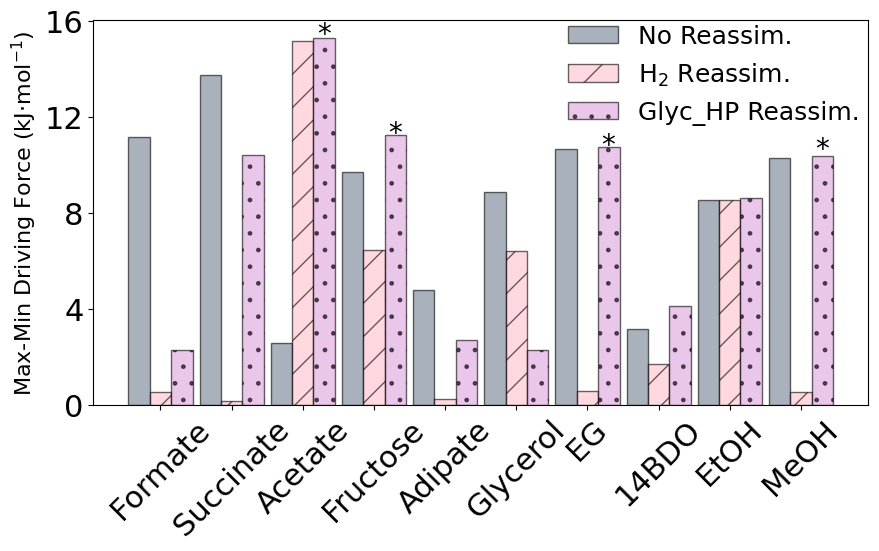

In [1069]:
x = np.arange(len(mdfs_prod.keys())-1) 
no_reassim = [mdfs_prod[x] for x in mdfs_prod.keys() if x != 'CO2']
h2_reassim = [mdfs_reassim_prod[x] for x in mdfs_reassim_prod.keys() if x != 'CO2']
glyc_reassim = [glyc_pairs_production[x][0] for x in glyc_pairs_production]

width = 0.3

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.bar(x-width, no_reassim, width, label = 'No Reassim.', alpha = 0.6, color = 'slategrey', edgecolor = "black")
ax.bar(x, h2_reassim, width, label = 'H$_2$ Reassim.', color = 'pink',
       hatch = '/', alpha = 0.6, edgecolor = "black")
ax.bar(x+width, glyc_reassim, width, label = 'Glyc_HP Reassim.', color = 'plum',
       hatch = '.', alpha = 0.6, edgecolor = "black")

ax.set_ylabel(r'Max-Min Driving Force (kJ$\cdot$mol$^{-1}$)', fontsize=16)
ax.tick_params(axis='both', labelsize=22)

ax.yaxis.set_major_locator(plt.MaxNLocator(5))

ax.text(2.2, 15.1, '*', fontsize=20)
ax.text(3.2, 11, '*', fontsize=20)
ax.text(6.2, 10.5, '*', fontsize=20)
ax.text(9.2, 10.3, '*', fontsize=20)

ax.legend(frameon=False, loc = (0.6,0.7), fontsize = 18)

_=ax.set_xticks(ticks = x, labels = [x for x in mdfs_reassim_prod.keys() if x!= 'CO2'], rotation =45)

#plt.savefig('reassim_reassim_comparison_glyc.pdf', bbox_inches = 'tight')